In [1]:
try:
    import numpy as np
    import seaborn as sns
    import pandas as pd
    import matplotlib.pyplot as plt
    import os
    import glob
    import math
    from tqdm import tqdm
    from scipy.stats import mannwhitneyu
except:
    %pip install numpy
    %pip install seaborn
    %pip install pandas
    %pip install matplotlib
    %pip install os-sys
    %pip install glob2
    %pip install python-math
    %pip install tqdm
    %pip install scipy

    import numpy as np
    import seaborn as sns
    import pandas as pd
    import matplotlib.pyplot as plt
    import os
    import glob
    import math
    from tqdm import tqdm
    from scipy.stats import mannwhitneyu

In [2]:
try:
    from StatTools.analysis.dpcca import dpcca
    from StatTools.analysis.movmean import movmean
except:
    %git clone https://github.com/alexandr-1k/StatTools
    %python setup.py install
    from StatTools.analysis.dpcca import dpcca
    from StatTools.analysis.movmean import movmean

### Fluctuation functions for the movement trajectories


In [3]:
data_path = os.path.join(os.getcwd(), 'data')
target_path = os.path.join(os.getcwd(), 'export')

In [4]:
# finding the minimum trajectory length
min_len = None
for csv_path in glob.glob(os.path.join(data_path, '*.csv')):
    df = pd.read_csv(csv_path, index_col=0)[['midbody_x', 'midbody_y']]
    df = df.dropna(axis=0, how='all')
    if min_len == None:
        min_len = df.shape[0]
    elif df.shape[0] < min_len:
        min_len = df.shape[0]
print('min:{}'.format(min_len))

min:11311


In [5]:
group_names = ['alz', 'wild']
columns_names_x = ['group', 'video_name', 'snout_x', 'leftforword_x',
                   'rightforword_x', 'midbody_x',
                   'leftback_x', 'rightback_x',
                   'tail_x']
columns_names_y = ['group', 'video_name', 'snout_y', 'leftforword_y',
                   'rightforword_y', 'midbody_y',
                   'leftback_y', 'rightback_y',
                   'tail_y']
parts_columns_names_x = ['snout_x', 'leftforword_x',
                         'rightforword_x', 'midbody_x',
                         'leftback_x', 'rightback_x',
                         'tail_x']
parts_columns_names_y = ['snout_y', 'leftforword_y',
                         'rightforword_y', 'midbody_y',
                         'leftback_y', 'rightback_y',
                         'tail_y']

After creating the csv files, one can visualize the fluctuation functions. First, DFA flucutations functions characterizing the auto-correlations in the individual movemens of each animal body part are displayed. Next, the DCCA joint fluctuation functions indicating mutual dynamics of animal body parts in terms of their cross-correlations are shown.
Here exemplified for one single Cartesian coordinate (e.g., "x"), could be duplicated for "y"

In [10]:
def get_joint_median_ff(data_file: str, columns_names: list):
    """
    return data_list(list): group, name and len(columns_names)^2 crossovers
    """
    data = pd.read_csv(data_file, index_col=0)[columns_names]
    data = data.dropna(axis=0, how='all')
    data.index = range(0, len(data))

    data_size = data.shape[0]  # Clipping trajectories to the minimum length
    drop_size = data_size-min_len
    data = data.drop(list(range(data_size-drop_size, data_size)))

    columns = ['file', 'group', 'name', 'f','s', 'crossover_position']
    data_df = pd.DataFrame([], columns = columns)
    file = os.path.splitext(os.path.basename(data_file))[0]  
    group = file.split('_')[-1]

    # dpcca for all cols
    base = 1.05
    smin = 8
    L = min_len
    smax = L/4
    S = []
    for degree in range(int(math.log2(smin)/math.log2(base)), int(math.log2(smax)/math.log2(base))):
        new = int(base**degree)
        if not new in S:
            S.append(new)

    for i, col_i in enumerate(columns_names):
        new_row = {}
        sum_f = None
        for j, col_j in enumerate(columns_names):
            if col_i==col_j:
                continue
            _, _, f, s = dpcca(movmean(np.concatenate(
                (data[col_i], data[col_j])), 5), pd=2, step=1, s=S, processes=2)
            try:
                sum_f = np.row_stack((sum_f,f))
            except:
                sum_f = f
        #median 1 body part with all others
        f = np.median(sum_f, axis = 0)
        new_f = movmean(f, 9)*np.power(s, -5/4)
        s_max_index = np.argmax(new_f)
        crossover_position = s[s_max_index]
        new_row['file'] = file
        new_row['group'] = group
        new_row['name'] = col_i + '_all'
        new_row['f'] = f
        new_row['s'] = s
        new_row['crossover_position'] = crossover_position
        data_df = data_df.append(new_row, ignore_index=True)

    #median 1 body part with itself
    for j, col_j in enumerate(columns_names):
        _, _, f, s = dpcca(movmean(data[col_j], 5), pd=2, step=1, s=S, processes=2)
        new_f = movmean(f, 9)*np.power(s, -5/4)
        s_max_index = np.argmax(new_f)
        crossover_position = s[s_max_index]
        new_row['file'] = file
        new_row['group'] = group
        new_row['name'] = col_j + '_' + col_j
        new_row['f'] = f
        new_row['s'] = s
        new_row['crossover_position'] = crossover_position
        data_df = data_df.append(new_row, ignore_index=True)
    return data_df

In [11]:
data_path = os.path.join(os.getcwd(), 'data')
target_path = os.path.join(os.getcwd(), 'export')

In [12]:
columns = ['file', 'group', 'name', 'f','s', 'crossover_position']
all_data_df = pd.DataFrame([], columns=columns)
for group_name in group_names:
    group_data_list = []
    for csv_path in tqdm(glob.glob(os.path.join(data_path, f'*{group_name}.csv'))):
        mouse_df=get_joint_median_ff(csv_path, parts_columns_names_x)
        all_data_df = pd.concat(
        [all_data_df, mouse_df], axis=0, ignore_index=True)
all_data_df.to_csv(os.path.join(target_path, "DCCA_data_x.csv"))

all_data_df = pd.DataFrame([], columns=columns)
for group_name in group_names:
    group_data_list = []
    for csv_path in tqdm(glob.glob(os.path.join(data_path, f'*{group_name}.csv'))):
        mouse_df=get_joint_median_ff(csv_path, parts_columns_names_y)
        all_data_df = pd.concat(
        [all_data_df, mouse_df], axis=0, ignore_index=True)
all_data_df.to_csv(os.path.join(target_path, "DCCA_data_y.csv"))

100%|██████████| 9/9 [31:13<00:00, 208.18s/it]


##### Results
After create csv files, we can visualisate fluctuation functions. First, graphs are plotted for each part of the mouse body. Then you can see integral graphs (DFA and DCCA).


Here is example for "x" coordinate, you need repeat it for "y".

In [6]:
#the path to data
data_path = os.path.join(os.getcwd(), 'export')

#the path to save plot
target_path = os.path.join(os.getcwd(), 'export')
os.makedirs(target_path, exist_ok=True)

data_file = os.path.join(data_path, 'DPCCA_data_x.csv') #change data path here for y
data = pd.read_csv(data_file, index_col=0)
data['crossover_position'] = pd.to_numeric(data['crossover_position'], downcast='integer')
body_parts = data.name.unique()
sns.set(font_scale=1.7, style='whitegrid')

In [7]:
body_parts_dict = {'snout_x_all':'A-all', 'leftforword_x_all': 'B-all', 'rightforword_x_all':'C-all', 'midbody_x_all':'D-all', 
            'leftback_x_all':'E-all', 'rightback_x_all':'F-all', 'tail_x_all':'G-all',
            'snout_x_snout_x':'A-A', 'leftforword_x_leftforword_x': 'B-B', 'rightforword_x_rightforword_x':'C-C', 'midbody_x_midbody_x':'D-D', 
            'leftback_x_leftback_x':'E-E', 'rightback_x_rightback_x':'F-F', 'tail_x_tail_x':'G-G',
            'snout_y_all':'A-all', 'leftforword_y_all': 'B-all', 'rightforword_y_all':'C-all', 'midbody_y_all':'D-all', 
            'leftback_y_all':'E-all', 'rightback_y_all':'F-all', 'tail_y_all':'G-all',
            'snout_y_snout_y':'A-A', 'leftforword_y_leftforword_y': 'B-B', 'rightforword_y_rightforword_y':'C-C', 'midbody_y_midbody_y':'D-D', 
            'leftback_y_leftback_y':'E-E', 'rightback_y_rightback_y':'F-F', 'tail_y_tail_y':'G-G'}

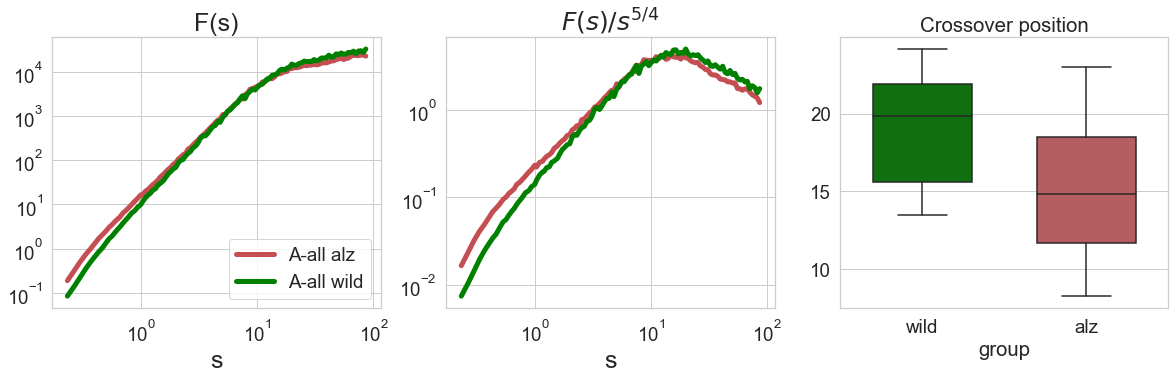

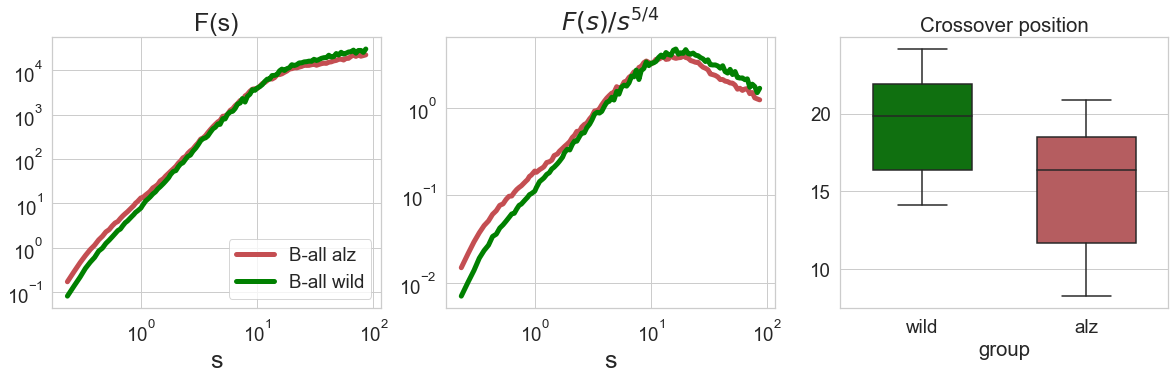

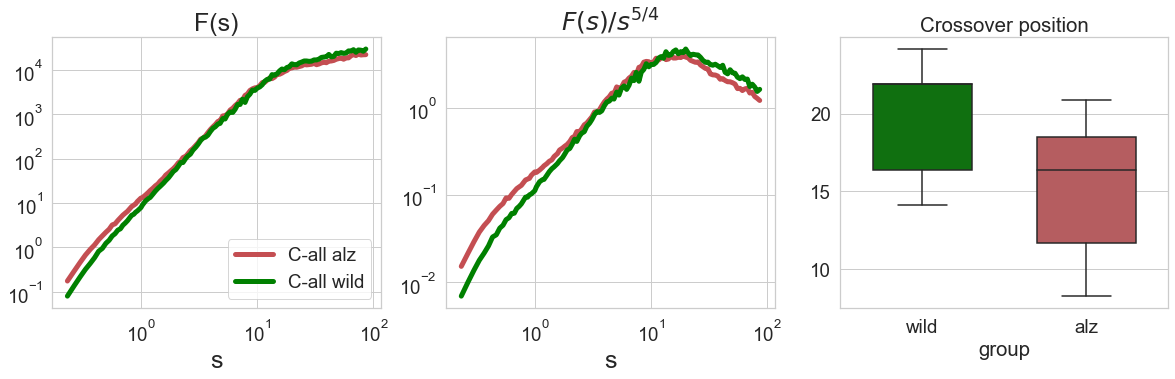

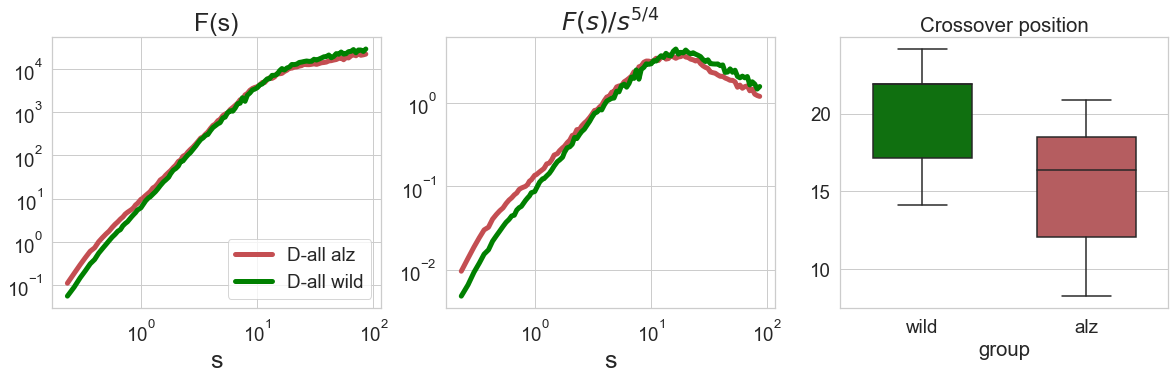

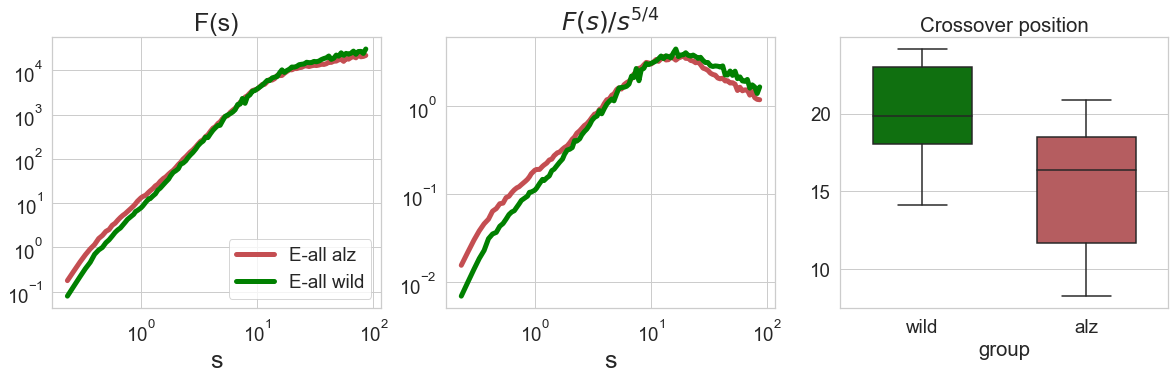

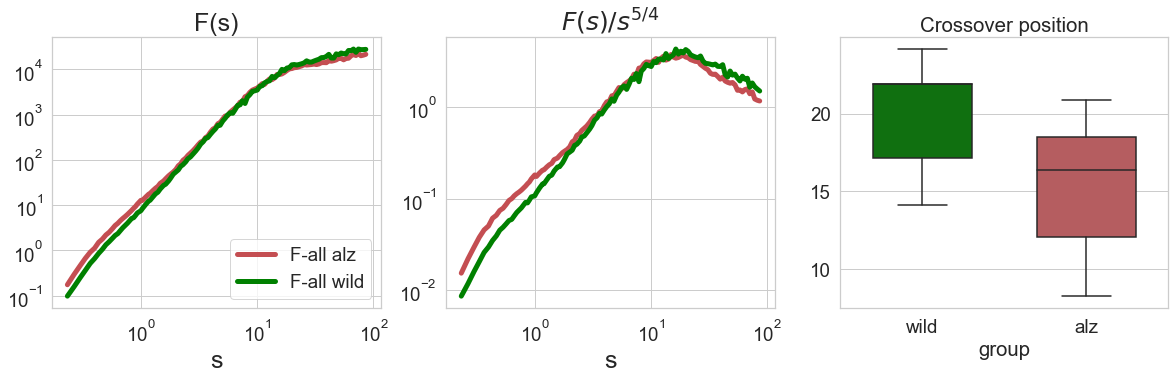

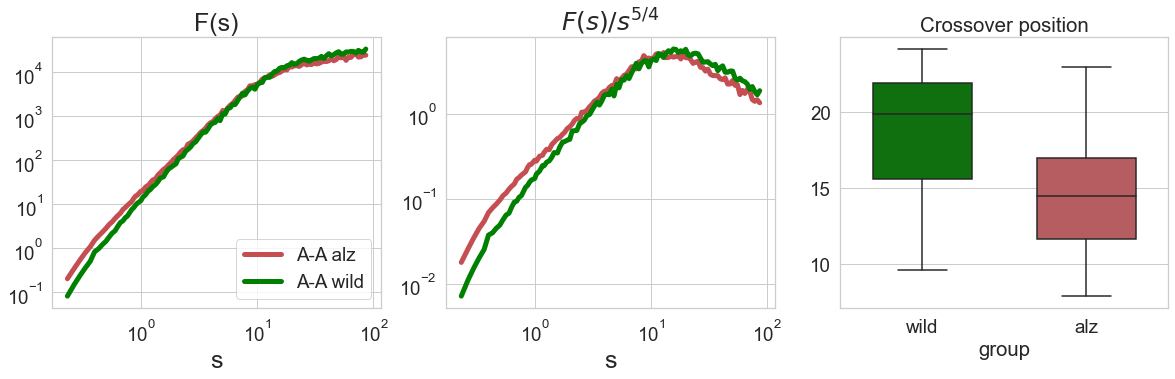

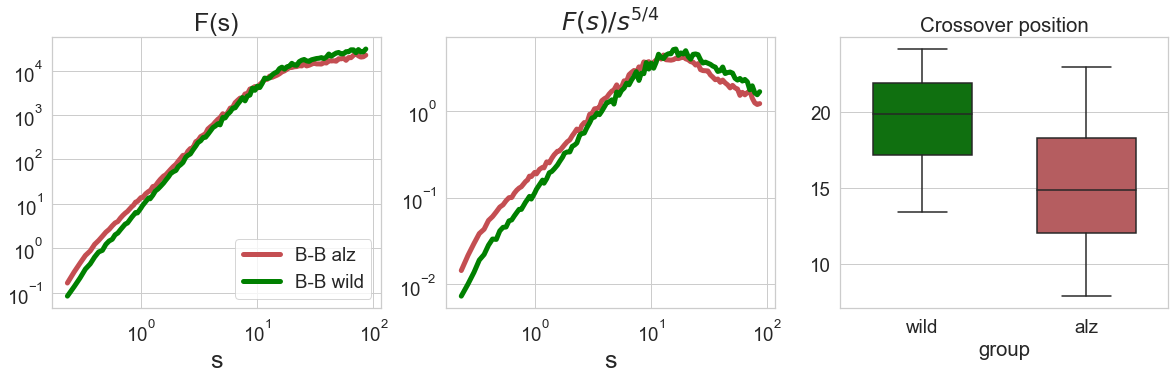

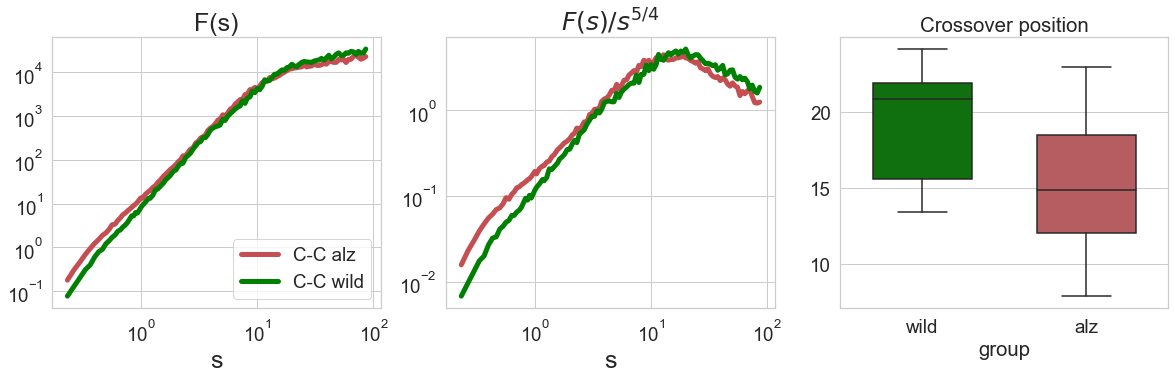

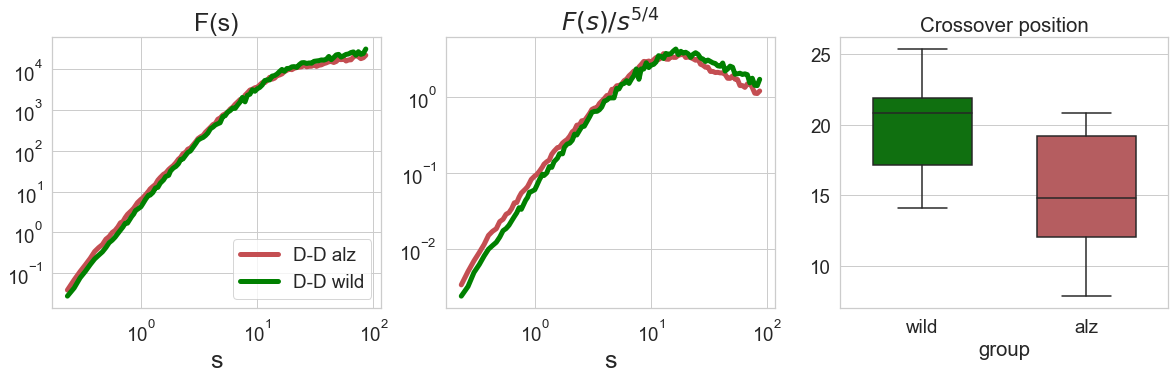

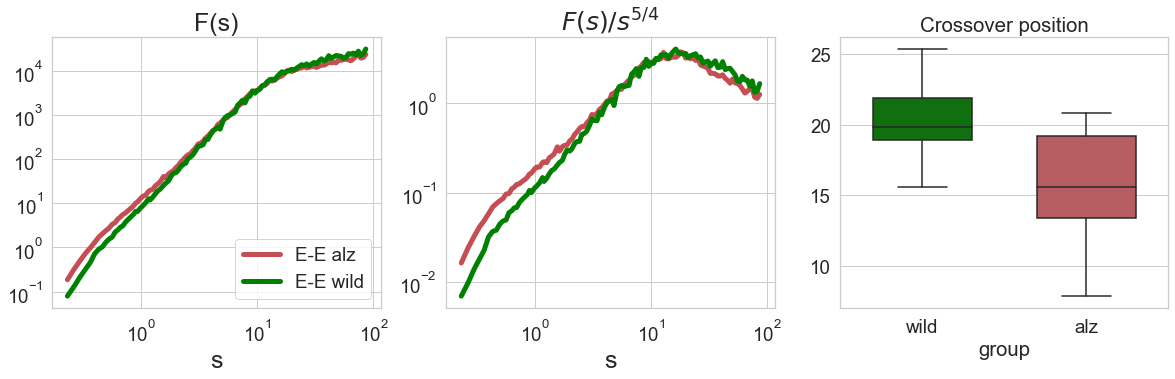

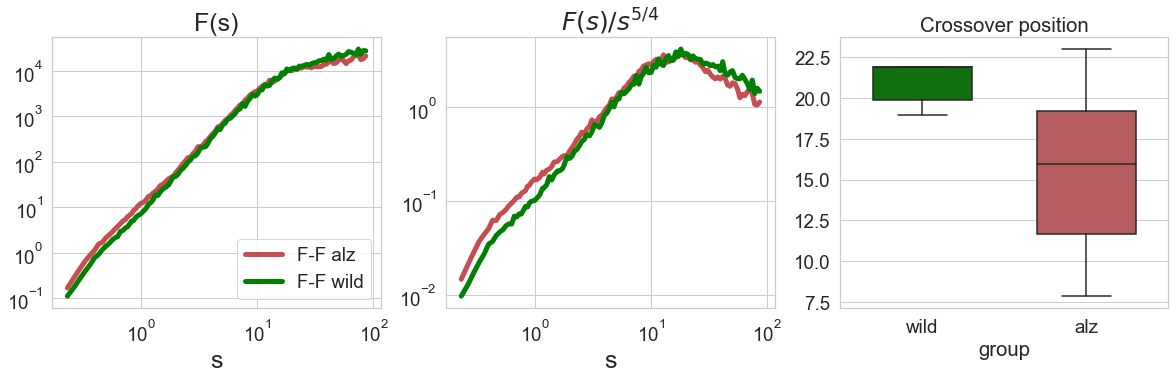

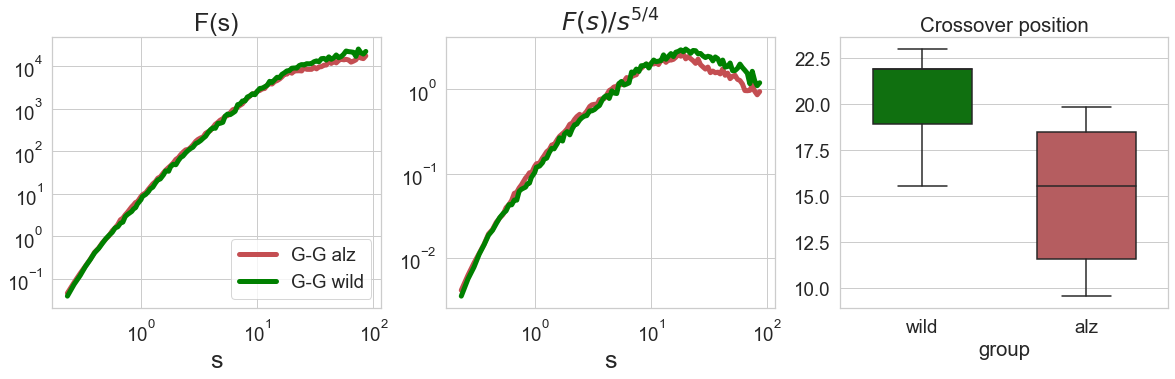

In [8]:
for body_part in body_parts:
    fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=False)
    flag_group = True
    body_part_df = data[data.name==body_part].reset_index(drop=True)
    body_part_df[body_part_df.columns[-1]] = body_part_df[body_part_df.columns[-1]]/30
    sum_f = None
    for n, row_n in enumerate(range(body_part_df.shape[0])):
        if body_part_df.loc[row_n]['group'] == 'alz':
            s = []
            for i in body_part_df.loc[row_n]['s'][1:-1].split(','):
                s.append(float(i))
            s = np.array(s)
            f = []
            for i in body_part_df.loc[row_n]['f'][1:-1].replace('\n', '').split(' '):
                f.append(float(i))
            try:
                sum_f = np.row_stack((sum_f,f))
                f_alz = np.median(sum_f, axis = 0)
            except:
                sum_f = f
        else:
            if flag_group:
                sum_f = None
                flag_group = False
            s = []
            for i in body_part_df.loc[row_n]['s'][1:-1].split(','):
                s.append(float(i))
            s = np.array(s)
            f = []
            for i in body_part_df.loc[row_n]['f'][1:-1].replace('\n', '').split(' '):
                f.append(float(i))
            try:
                sum_f = np.row_stack((sum_f,f))
                f_wild = np.median(sum_f, axis = 0)
            except:
                sum_f = f
        
    axs[0].loglog(s/30, f_alz, linewidth=5, label=body_parts_dict[body_part] + ' alz', color='r')
    axs[0].loglog(s/30, f_wild, linewidth=5, label=body_parts_dict[body_part] + ' wild', color='green')

    f_alz = f_alz*np.power(s, -5/4)
    f_wild = f_wild*np.power(s, -5/4)  

    axs[1].loglog(s/30, f_alz, linewidth=5, color='r')
    axs[1].loglog(s/30, f_wild, linewidth=5, color='green')

    axs[0].grid(True) 
    axs[0].set_title('F(s)', fontsize=25)
    axs[0].set_xlabel('s', fontsize=25)
    axs[0].legend(loc='lower right')

    axs[1].grid(True)
    axs[1].set_xlabel('s', fontsize=25)
    axs[1].set_title(r'$F(s)/s^{5/4}$', fontsize=25)

    axs[2].set_title('Crossover position')
    axs[2] = sns.boxplot(x=body_part_df["group"], y=body_part_df['crossover_position'], data=body_part_df, order=['wild', 'alz'], width=0.6, showfliers=False, palette=[
                    'green', 'r'], dodge=False).set(ylabel=' ',)

    # plt.savefig(os.path.join(target_path, f'{body_parts_dict[body_part]}_y.eps'), format = "eps", bbox_inches='tight')
    plt.show()

Integral graphs

In [9]:
body_parts_dict_dfa = {
            'snout_x_snout_x':'A-A', 'leftforword_x_leftforword_x': 'B-B', 'rightforword_x_rightforword_x':'C-C', 'midbody_x_midbody_x':'D-D', 
            'leftback_x_leftback_x':'E-E', 'rightback_x_rightback_x':'F-F', 'tail_x_tail_x':'G-G',
            'snout_y_snout_y':'A-A', 'leftforword_y_leftforword_y': 'B-B', 'rightforword_y_rightforword_y':'C-C', 'midbody_y_midbody_y':'D-D', 
            'leftback_y_leftback_y':'E-E', 'rightback_y_rightback_y':'F-F', 'tail_y_tail_y':'G-G',
            }
body_parts_dict_dcca = {
            'snout_x_all':'A-all', 'leftforword_x_all': 'B-all', 'rightforword_x_all':'C-all', 'midbody_x_all':'D-all', 
            'leftback_x_all':'E-all', 'rightback_x_all':'F-all', 'tail_x_all':'G-all',
            'snout_y_all':'A-all', 'leftforword_y_all': 'B-all', 'rightforword_y_all':'C-all', 'midbody_y_all':'D-all', 
            'leftback_y_all':'E-all', 'rightback_y_all':'F-all', 'tail_y_all':'G-all',
            }

In [10]:
#graph body_parts dfa
all_body_parts_f_alz = None
all_body_parts_f_wild = None
all_body_part_df = pd.DataFrame([], columns=[])
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=False)

for body_part in body_parts:
    if not body_part in body_parts_dict_dfa:
        continue
    flag_group = True
    body_part_df = data[data.name==body_part].reset_index(drop=True)
    body_part_df[body_part_df.columns[-1]] = body_part_df[body_part_df.columns[-1]]/30
    all_body_part_df = pd.concat(
        [all_body_part_df, body_part_df], axis=0, ignore_index=True)
    sum_f = None
    for n, row_n in enumerate(range(body_part_df.shape[0])):
        if body_part_df.loc[row_n]['group'] == 'alz':
            s = []
            for i in body_part_df.loc[row_n]['s'][1:-1].split(','):
                s.append(float(i))
            s = np.array(s)
            f = []
            for i in body_part_df.loc[row_n]['f'][1:-1].replace('\n', '').split(' '):
                f.append(float(i))
            try:
                sum_f = np.row_stack((sum_f,f))
                f_alz = np.median(sum_f, axis = 0)
            except:
                sum_f = f
        else:
            if flag_group:
                sum_f = None
                flag_group = False
            s = []
            for i in body_part_df.loc[row_n]['s'][1:-1].split(','):
                s.append(float(i))
            s = np.array(s)
            f = []
            for i in body_part_df.loc[row_n]['f'][1:-1].replace('\n', '').split(' '):
                f.append(float(i))
            try:
                sum_f = np.row_stack((sum_f,f))
                f_wild = np.median(sum_f, axis = 0)
            except:
                sum_f = f
    try:
        all_body_parts_f_alz = np.row_stack((all_body_parts_f_alz, f_alz))
        all_body_parts_f_alz = np.median(all_body_parts_f_alz, axis = 0)
        all_body_parts_f_wild = np.row_stack((all_body_parts_f_wild, f_wild))
        all_body_parts_f_wild = np.median(all_body_parts_f_wild, axis = 0)
    except:
        all_body_parts_f_alz = f_alz
        all_body_parts_f_wild = f_wild

axs[0].loglog(s/30, all_body_parts_f_alz, linewidth=5, label='alz', color='r')
axs[0].loglog(s/30, all_body_parts_f_wild, linewidth=5, label='wild', color='green')

all_body_parts_f_alz = all_body_parts_f_alz*np.power(s, -5/4)
all_body_parts_f_wild = all_body_parts_f_wild*np.power(s, -5/4)  

axs[1].loglog(s/30, all_body_parts_f_alz, linewidth=5, color='r')
axs[1].loglog(s/30, all_body_parts_f_wild, linewidth=5, color='green')

axs[0].grid(True) 
axs[0].set_title('F(s)', fontsize=25)
axs[0].set_xlabel('s', fontsize=25)
axs[0].legend(loc='lower right')

axs[1].grid(True)
axs[1].set_xlabel('s', fontsize=25)
axs[1].set_title(r'$F(s)/s^{5/4}$', fontsize=25)

axs[2].set_title('Crossover position')
axs[2] = sns.boxplot(x=all_body_part_df["group"], y=all_body_part_df['crossover_position'], data=all_body_part_df, order=['wild', 'alz'], width=0.6, showfliers=False, palette=[
                'green', 'r'], dodge=False).set(ylabel=' ',)

# plt.savefig(os.path.join(target_path, f'dfa_x.eps'), format = "eps", bbox_inches='tight')
plt.show()

In [11]:
# the Mann-Whitney U-test
x = all_body_part_df[all_body_part_df['group'] == 'alz']['crossover_position']
y = all_body_part_df[all_body_part_df['group'] == 'wild']['crossover_position']
U1, p = mannwhitneyu(np.array(x).astype(float), np.array(y).astype(float), alternative='two-sided')
print(f'p-value dfa X: {np.round(p,10)}')

p-value dfa X: 2.371e-07


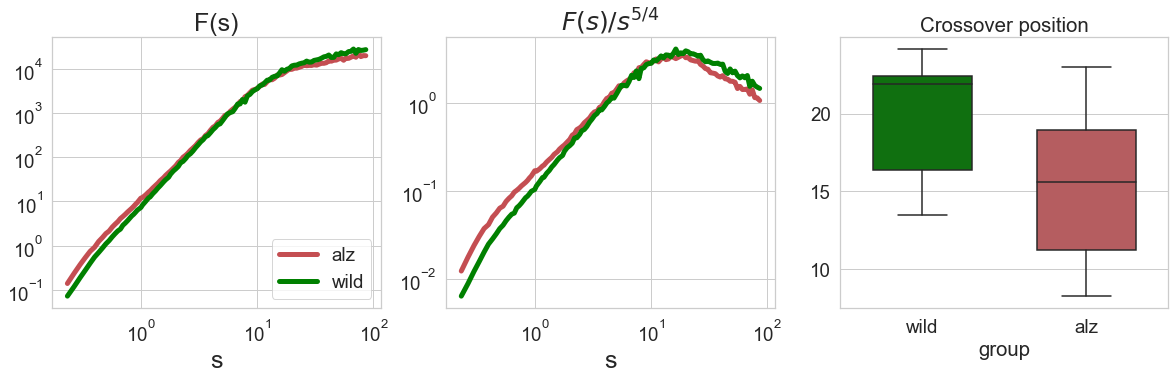

In [12]:
#graph body_parts dcca
all_body_parts_f_alz = None
all_body_parts_f_wild = None
all_body_part_df = pd.DataFrame([], columns=[])
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=False)

for body_part in body_parts:
    if not body_part in body_parts_dict_dcca:
        continue
    flag_group = True
    body_part_df = data[data.name==body_part].reset_index(drop=True)
    body_part_df[body_part_df.columns[-1]] = body_part_df[body_part_df.columns[-1]]/30
    all_body_part_df = pd.concat(
        [all_body_part_df, body_part_df], axis=0, ignore_index=True)
    sum_f = None
    for n, row_n in enumerate(range(body_part_df.shape[0])):
        if body_part_df.loc[row_n]['group'] == 'alz':
            s = []
            for i in body_part_df.loc[row_n]['s'][1:-1].split(','):
                s.append(float(i))
            s = np.array(s)
            f = []
            for i in body_part_df.loc[row_n]['f'][1:-1].replace('\n', '').split(' '):
                f.append(float(i))
            try:
                sum_f = np.row_stack((sum_f,f))
                f_alz = np.median(sum_f, axis = 0)
            except:
                sum_f = f
        else:
            if flag_group:
                sum_f = None
                flag_group = False
            s = []
            for i in body_part_df.loc[row_n]['s'][1:-1].split(','):
                s.append(float(i))
            s = np.array(s)
            f = []
            for i in body_part_df.loc[row_n]['f'][1:-1].replace('\n', '').split(' '):
                f.append(float(i))
            try:
                sum_f = np.row_stack((sum_f,f))
                f_wild = np.median(sum_f, axis = 0)
            except:
                sum_f = f
        
    try:
        all_body_parts_f_alz = np.row_stack((all_body_parts_f_alz, f_alz))
        all_body_parts_f_alz = np.median(all_body_parts_f_alz, axis = 0)
        all_body_parts_f_wild = np.row_stack((all_body_parts_f_wild, f_wild))
        all_body_parts_f_wild = np.median(all_body_parts_f_wild, axis = 0)
    except:
        all_body_parts_f_alz = f_alz
        all_body_parts_f_wild = f_wild

axs[0].loglog(s/30, all_body_parts_f_alz, linewidth=5, label='alz', color='r')
axs[0].loglog(s/30, all_body_parts_f_wild, linewidth=5, label='wild', color='green')


all_body_parts_f_alz = all_body_parts_f_alz*np.power(s, -5/4)
all_body_parts_f_wild = all_body_parts_f_wild*np.power(s, -5/4)  

axs[1].loglog(s/30, all_body_parts_f_alz, linewidth=5, color='r')
axs[1].loglog(s/30, all_body_parts_f_wild, linewidth=5, color='green')

axs[0].grid(True) 
axs[0].set_title('F(s)', fontsize=25)
axs[0].set_xlabel('s', fontsize=25)
axs[0].legend(loc='lower right')

axs[1].grid(True)
axs[1].set_xlabel('s', fontsize=25)
axs[1].set_title(r'$F(s)/s^{5/4}$', fontsize=25)

axs[2].set_title('Crossover position')
axs[2] = sns.boxplot(x=all_body_part_df["group"], y=all_body_part_df['crossover_position'], data=all_body_part_df, order=['wild', 'alz'], width=0.6, showfliers=False, palette=[
                'green', 'r'], dodge=False).set(ylabel=' ',)

# plt.savefig(os.path.join(target_path, f'dcca_x.eps'), format = "eps", bbox_inches='tight')
plt.show()

In [13]:
# the Mann-Whitney U-test
x = all_body_part_df[all_body_part_df['group'] == 'alz']['crossover_position']
y = all_body_part_df[all_body_part_df['group'] == 'wild']['crossover_position']
U1, p = mannwhitneyu(np.array(x).astype(float), np.array(y).astype(float), alternative='two-sided')

print(f'p-value dcca X: {np.round(p,10)}')

p-value dcca X: 1.369e-07
